<a href="https://colab.research.google.com/github/13Aluminium/RESEARCH/blob/main/RESEARCH_0_T5_BASE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/13Aluminium/RESEARCH

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments
)

# Load datasets
train_df = pd.read_csv('/content/RESEARCH/0_ZEROTH_GEN_DATA/WebScrap/0_iteration_Train.tsv', sep='\t')
valid_df = pd.read_csv('/content/RESEARCH/0_ZEROTH_GEN_DATA/WebScrap/0_iteration_Validation.tsv', sep='\t')
test_df = pd.read_csv('/content/RESEARCH/0_ZEROTH_GEN_DATA/WebScrap/0_iteration_Test.tsv', sep='\t')

# Convert pandas DataFrame to Hugging Face Dataset
data = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(valid_df),
    'test': Dataset.from_pandas(test_df)
})

# Load T5 tokenizer and model
model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Enable gradient checkpointing for memory optimization
model.gradient_checkpointing_enable()

# Define preprocessing function
def preprocess_function(examples):
    inputs = ["translate English to Hinglish: " + ex for ex in examples["en_query"]]
    model_inputs = tokenizer(inputs, max_length=64, truncation=True)  # Reduced max_length

    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["cs_query"], max_length=64, truncation=True)
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

# Tokenize dataset
tokenized_data = data.map(preprocess_function, batched=True)

# Training arguments (GPU training)
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,   # Lower batch size to avoid OOM
    per_device_eval_batch_size=8,    # Lower batch size
    gradient_accumulation_steps=2,   # Accumulate gradients for effective batch size of 16
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=45,
    logging_dir='./logs',
    logging_steps=50,
    report_to=[]
)

# Data collator for dynamic padding
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Initialize Trainer (GPU training)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Training on GPU
trainer.train()

# Save the trained model
trainer.save_model("./final_model")

# Clear CUDA Cache
torch.cuda.empty_cache()

# Print completion message
print("Model training and saving completed successfully.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/2993 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1390 [00:00<?, ? examples/s]

Map:   0%|          | 0/6513 [00:00<?, ? examples/s]

<ipython-input-3-c738b731fc96>:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
1,2.693900,2.199645
2,2.151700,1.830355
3,1.914400,1.642675
4,1.738500,1.510261
5,1.649600,1.414822
6,1.555100,1.347713
7,1.430300,1.282657
8,1.343500,1.232277
9,1.273400,1.181595
10,1.231100,1.152950


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Model training and saving completed successfully.


In [ ]:
import torch
import pandas as pd
import sys
import traceback
from transformers import T5Tokenizer, T5ForConditionalGeneration

def minimal_debug_inference(model_path, test_file_path):
    print("Starting minimal debug inference...")

    try:
        # Print Python and library versions
        print(f"Python Version: {sys.version}")
        print(f"PyTorch Version: {torch.__version__}")
        print(f"Transformers Version: {torch.__version__}")

        # Load test data with verbose error handling
        print("Attempting to load test dataset...")
        try:
            test_df = pd.read_csv(test_file_path, sep='\t')
            print(f"Loaded dataset: {len(test_df)} samples")
            print(f"Columns: {list(test_df.columns)}")
        except Exception as data_error:
            print(f"❌ DATA LOADING ERROR: {data_error}")
            print(traceback.format_exc())
            return

        # Validate required columns
        if 'en_query' not in test_df.columns:
            print("❌ ERROR: 'en_query' column not found in dataset!")
            print("Available columns:", list(test_df.columns))
            return

        # Load tokenizer with verbose error handling
        print("Attempting to load tokenizer...")
        try:
            tokenizer = T5Tokenizer.from_pretrained("t5-base")
        except Exception as tokenizer_error:
            print(f"❌ TOKENIZER LOADING ERROR: {tokenizer_error}")
            print(traceback.format_exc())
            return

        # Load model with verbose error handling
        print("Attempting to load model...")
        try:
            model = T5ForConditionalGeneration.from_pretrained(model_path)
        except Exception as model_error:
            print(f"❌ MODEL LOADING ERROR: {model_error}")
            print(traceback.format_exc())

            # Check model directory contents
            import os
            print("\nChecking model directory contents:")
            try:
                print(os.listdir(model_path))
            except Exception as dir_error:
                print(f"Could not list directory: {dir_error}")
            return

        # Prepare device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Running on device: {device}")
        model.to(device)
        model.eval()

        # Prepare inputs
        print("Preparing model inputs...")
        inputs = ["translate English to Hinglish: " + str(ex) for ex in test_df["en_query"][:5]]

        # Tokenize
        print("Tokenizing inputs...")
        encodings = tokenizer(
            inputs,
            max_length=64,
            truncation=True,
            padding=True,
            return_tensors="pt"
        )

        # Inference
        print("Starting inference...")
        with torch.no_grad():
            outputs = model.generate(
                input_ids=encodings['input_ids'].to(device),
                max_length=64,
                num_beams=4,
                early_stopping=True
            )

        # Decode predictions
        predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Print results
        print("\n=== SAMPLE PREDICTIONS ===")
        for orig, trans in zip(inputs, predictions):
            print(f"Original: {orig}")
            print(f"Translation: {trans}")
            print("---")

        print("Inference completed successfully!")

    except Exception as e:
        print(f"❌ UNEXPECTED ERROR: {e}")
        print(traceback.format_exc())

# Main execution
if __name__ == "__main__":
    minimal_debug_inference(
        model_path="/content/final_model",
        test_file_path='/content/RESEARCH/0_ZEROTH_GEN_DATA/WebScrap/0_iteration_Test.tsv'
    )


Starting minimal debug inference...
Python Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch Version: 2.6.0+cu124
Transformers Version: 2.6.0+cu124
Attempting to load test dataset...
Loaded dataset: 6513 samples
Columns: ['en_query', 'cs_query', 'en_parse', 'cs_parse', 'domain']
Attempting to load tokenizer...
Attempting to load model...
Running on device: cuda
Preparing model inputs...
Tokenizing inputs...
Starting inference...

=== SAMPLE PREDICTIONS ===
Original: translate English to Hinglish: Pause my timer .
Translation: mere timer ko rok do
---
Original: translate English to Hinglish: Is it raining in Hawaii ?
Translation: Kya Hawaii me baarish hone wali hai ?
---
Original: translate English to Hinglish: Set a reminder for me to wake up at 630 am tomorrow .
Translation: Muje kal 630 am ke liye ek reminder set kare
---
Original: translate English to Hinglish: Please pause timer
Translation: Please timer ko pause kare
---
Original: translate English to Hinglish: p

In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.3 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
import sacrebleu

from transformers import T5Tokenizer, T5ForConditionalGeneration

def compute_bleu_metric(predictions, references):
    """
    Compute BLEU score using sacreBLEU.

    Args:
        predictions (list of str): Model-generated translations
        references (list of str): Ground-truth translations

    Returns:
        float: BLEU score
    """
    # sacreBLEU expects references in a list of lists
    bleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
    return bleu_score

def evaluate_model(
    model_path,
    data_file,
    row_limit=500,
    max_length=64,
    num_beams=4
):
    """
    Load the model and dataset, generate translations, and compute BLEU metric.

    Args:
        model_path (str): Path to the saved T5 model directory
        data_file (str): Path to the TSV file with columns [en_query, cs_query, ...]
        row_limit (int): Maximum number of rows to use from the dataset
        max_length (int): Max length for generated translations
        num_beams (int): Number of beams for beam search
    """
    print("Loading dataset for evaluation...")
    df = pd.read_csv(data_file, sep='\t')

    # We need 'en_query' as input and 'cs_query' as reference
    if 'en_query' not in df.columns or 'cs_query' not in df.columns:
        raise ValueError("Data file must contain 'en_query' and 'cs_query' columns!")

    # Limit rows for faster evaluation
    df = df.head(row_limit)

    # Prepare model & tokenizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = T5Tokenizer.from_pretrained("t5-large")
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    model.to(device)
    model.eval()

    # Generate predictions
    predictions = []
    references = []

    print(f"Generating translations for up to {len(df)} rows...")

    for _, row in df.iterrows():
        # Prepare input text
        input_text = "translate English to Hinglish: " + str(row['en_query'])

        # Tokenize
        encodings = tokenizer(
            input_text,
            max_length=max_length,
            truncation=True,
            return_tensors="pt"
        ).to(device)

        # Generate
        with torch.no_grad():
            outputs = model.generate(
                input_ids=encodings['input_ids'],
                attention_mask=encodings['attention_mask'],
                max_length=max_length,
                num_beams=num_beams,
                early_stopping=True
            )

        # Decode prediction
        pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Append prediction and reference
        predictions.append(pred_text)
        references.append(str(row['cs_query']))

    print("Done generating translations. Now computing BLEU metric...")

    # Compute BLEU metric
    bleu_score = compute_bleu_metric(predictions, references)

    # Print metric
    print("\n=== Evaluation Metric ===")
    print(f"BLEU Score: {bleu_score:.4f}")

    return bleu_score

def main():
    # Example usage
    model_path = "/content/final_model"  # Adjust if needed
    data_file = "/content/RESEARCH/0_ZEROTH_GEN_DATA/SynGen/0_iteration_Train_500.tsv" # Adjust path if needed

    # Evaluate on up to 500 rows from the train file
    evaluate_model(
        model_path=model_path,
        data_file=data_file,
        row_limit=500,       # Adjust as needed (200, 500, 1000, etc.)
        max_length=64,
        num_beams=4
    )

if __name__ == "__main__":
    main()

Loading dataset for evaluation...


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Generating translations for up to 500 rows...
Done generating translations. Now computing BLEU metric...

=== Evaluation Metric ===
BLEU Score: 41.9244


In [ ]:
import torch
import pandas as pd
import numpy as np
import sacrebleu
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoModel, AutoTokenizer

def levenshtein_distance(s1, s2):
    """
    Compute Levenshtein distance between two strings
    Supports both word and character-level distance
    """
    # If input is string, convert to list of characters/words
    if isinstance(s1, str):
        s1 = list(s1)
    if isinstance(s2, str):
        s2 = list(s2)

    # Create distance matrix
    rows, cols = len(s1) + 1, len(s2) + 1
    dist = [[0 for x in range(cols)] for x in range(rows)]

    # Initialize first row and column
    for i in range(1, rows):
        dist[i][0] = i
    for j in range(1, cols):
        dist[0][j] = j

    # Compute Levenshtein distance
    for col in range(1, cols):
        for row in range(1, rows):
            if s1[row-1] == s2[col-1]:
                cost = 0
            else:
                cost = 1
            dist[row][col] = min(
                dist[row-1][col] + 1,      # deletion
                dist[row][col-1] + 1,      # insertion
                dist[row-1][col-1] + cost  # substitution
            )

    return dist[rows-1][cols-1]

def word_error_rate(reference, hypothesis):
    """
    Compute Word Error Rate (WER)
    Lower is better (0 is perfect match)
    """
    # Split into words
    r = reference.split()
    h = hypothesis.split()

    # Compute Levenshtein distance
    return levenshtein_distance(r, h) / len(r)

def character_error_rate(reference, hypothesis):
    """
    Compute Character Error Rate (CER)
    Lower is better (0 is perfect match)
    """
    return levenshtein_distance(reference, hypothesis) / len(reference)

def compute_embedding_similarity(reference, hypothesis, model_name='distilbert-base-uncased'):
    """
    Compute cosine similarity between sentence embeddings
    Higher is better (1 is perfect similarity)
    """
    try:
        # Load pre-trained model and tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)

        # Tokenize and get embeddings
        inputs_ref = tokenizer(reference, return_tensors='pt', truncation=True, max_length=512)
        inputs_hyp = tokenizer(hypothesis, return_tensors='pt', truncation=True, max_length=512)

        # Generate embeddings
        with torch.no_grad():
            outputs_ref = model(**inputs_ref)
            outputs_hyp = model(**inputs_hyp)

        # Mean pooling
        ref_embedding = outputs_ref.last_hidden_state.mean(dim=1)
        hyp_embedding = outputs_hyp.last_hidden_state.mean(dim=1)

        # Compute cosine similarity
        return 1 - torch.nn.functional.cosine_similarity(ref_embedding, hyp_embedding).item()
    except Exception as e:
        print(f"Error in embedding similarity: {e}")
        return None

def evaluate_model_metrics(
    model_path,
    data_file,
    row_limit=500,
    max_length=64,
    num_beams=4
):
    """
    Comprehensive model evaluation with multiple metrics
    """
    print("Loading dataset for evaluation...")
    df = pd.read_csv(data_file, sep='\t')

    # Validate columns
    if 'en_query' not in df.columns or 'cs_query' not in df.columns:
        raise ValueError("Data file must contain 'en_query' and 'cs_query' columns!")

    # Limit rows
    df = df.head(row_limit)

    # Prepare model & tokenizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    model.to(device)
    model.eval()

    # Metrics storage
    metrics = {
        'bleu_scores': [],
        'wer_scores': [],
        'cer_scores': [],
        'embedding_similarities': []
    }

    print(f"Generating translations for up to {len(df)} rows...")

    for _, row in df.iterrows():
        # Prepare input text
        input_text = "translate English to Hinglish: " + str(row['en_query'])
        reference = str(row['cs_query'])

        # Tokenize
        encodings = tokenizer(
            input_text,
            max_length=max_length,
            truncation=True,
            return_tensors="pt"
        ).to(device)

        # Generate
        with torch.no_grad():
            outputs = model.generate(
                input_ids=encodings['input_ids'],
                attention_mask=encodings['attention_mask'],
                max_length=max_length,
                num_beams=num_beams,
                early_stopping=True
            )

        # Decode prediction
        hypothesis = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Compute metrics
        # BLEU
        bleu_score = sacrebleu.sentence_bleu(hypothesis, [reference]).score
        metrics['bleu_scores'].append(bleu_score)

        # Word Error Rate
        wer = word_error_rate(reference, hypothesis)
        metrics['wer_scores'].append(wer)

        # Character Error Rate
        cer = character_error_rate(reference, hypothesis)
        metrics['cer_scores'].append(cer)

        # Embedding Similarity
        emb_sim = compute_embedding_similarity(reference, hypothesis)
        if emb_sim is not None:
            metrics['embedding_similarities'].append(emb_sim)

        # Optional: print individual sample results
        print(f"\nReference: {reference}")
        print(f"Hypothesis: {hypothesis}")
        print(f"BLEU: {bleu_score:.4f}, WER: {wer:.4f}, CER: {cer:.4f}")

    # Compute average metrics
    print("\n=== Evaluation Metrics ===")
    print(f"Average BLEU Score: {np.mean(metrics['bleu_scores']):.4f}")
    print(f"Average Word Error Rate: {np.mean(metrics['wer_scores']):.4f}")
    print(f"Average Character Error Rate: {np.mean(metrics['cer_scores']):.4f}")
    if metrics['embedding_similarities']:
        print(f"Average Embedding Similarity: {np.mean(metrics['embedding_similarities']):.4f}")

    return metrics

def main():
    # Example usage
    model_path = "/content/final_model"  # Adjust if needed
    data_file = "/content/RESEARCH/0_ZEROTH_GEN_DATA/SynGen/0_iteration_Train_500.tsv" # Adjust path if needed

    # Evaluate on up to 500 rows from the train file
    evaluate_model_metrics(
        model_path=model_path,
        data_file=data_file,
        row_limit=500,
        max_length=64,
        num_beams=4
    )

if __name__ == "__main__":
    main()

Loading dataset for evaluation...


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Generating translations for up to 500 rows...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Reference: Is Saturday night The Grand Ole Opry me featured performer kya hai
Hypothesis: Is Saturday night The Grand Ole Opry par featured performer kya he
BLEU: 63.4047, WER: 0.1667, CER: 0.0758

Reference: mujhe 12 am ko meri meeting ke baare me yaad dilaayen
Hypothesis: mujhe 12 am ko mere meeting ke liye yaad dilaye
BLEU: 29.3772, WER: 0.3636, CER: 0.1887

Reference: subha 5 baje ke liye ek alarm set karen
Hypothesis: subah 5 baje ke liye alarm set kare
BLEU: 36.2824, WER: 0.3333, CER: 0.1538

Reference: dopaher 2 baje Sydney me mausam kaisa hoga
Hypothesis: Sydney me 2 pm ko mausam kaisa hone wala hai
BLEU: 12.5493, WER: 1.0000, CER: 0.6905

Reference: Canada me mausam kaisa hai ?
Hypothesis: Canada me mausam kaisa hai
BLEU: 81.8731, WER: 0.1667, CER: 0.0714

Reference: weekend alarm ko delete karo
Hypothesis: weekend alarm ko delete kare
BLEU: 66.8740, WER: 0.2000, CER: 0.0357

Reference: abhi ka temperature kya hai
Hypothesis: abhi temperature kya hai
BLEU: 49.7609, WER: 0.200

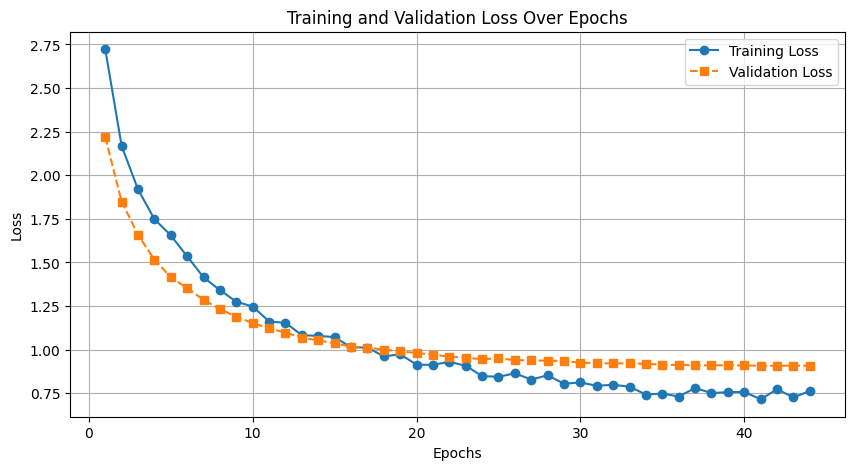

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(1, 45))
training_loss = [2.722500, 2.167800, 1.918700, 1.748200, 1.655000, 1.534900, 1.414200, 1.341200, 1.274400, 1.247000,
                 1.161000, 1.153300, 1.082900, 1.078200, 1.071800, 1.013000, 1.011800, 0.961200, 0.972900, 0.913800,
                 0.912400, 0.929600, 0.907700, 0.848000, 0.843900, 0.864200, 0.828200, 0.852600, 0.804300, 0.811700,
                 0.792400, 0.798400, 0.787000, 0.742300, 0.747900, 0.730900, 0.779500, 0.750900, 0.755800, 0.757300,
                 0.715400, 0.772400, 0.726200, 0.762200]
validation_loss = [2.218311, 1.849125, 1.658101, 1.515976, 1.415526, 1.351700, 1.285454, 1.232165, 1.188866, 1.151759,
                   1.122790, 1.097199, 1.068513, 1.053197, 1.035365, 1.017515, 1.010678, 0.999789, 0.990175, 0.980170,
                   0.971844, 0.958877, 0.953647, 0.945198, 0.949954, 0.939426, 0.937722, 0.936495, 0.934446, 0.925024,
                   0.922332, 0.920682, 0.921493, 0.918203, 0.913686, 0.911861, 0.909752, 0.909588, 0.910192, 0.909320,
                   0.907287, 0.906901, 0.908157, 0.907242]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


<ipython-input-11-56cb978e3ebd>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_WER', y='word', data=top_wer, palette='viridis')


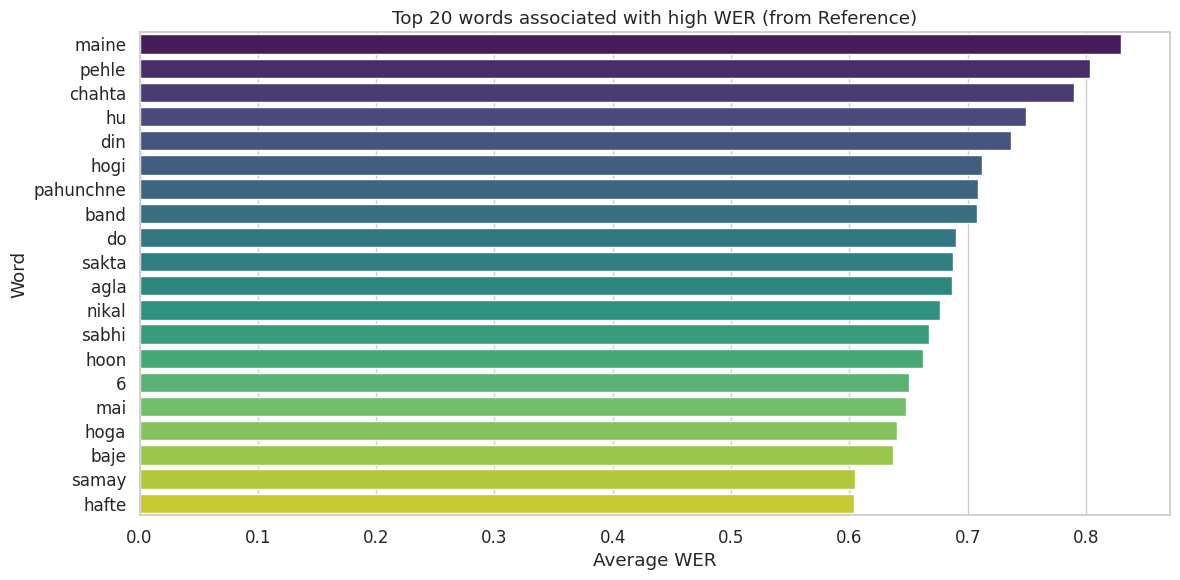

<ipython-input-11-56cb978e3ebd>:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_CER', y='word', data=top_cer, palette='rocket')


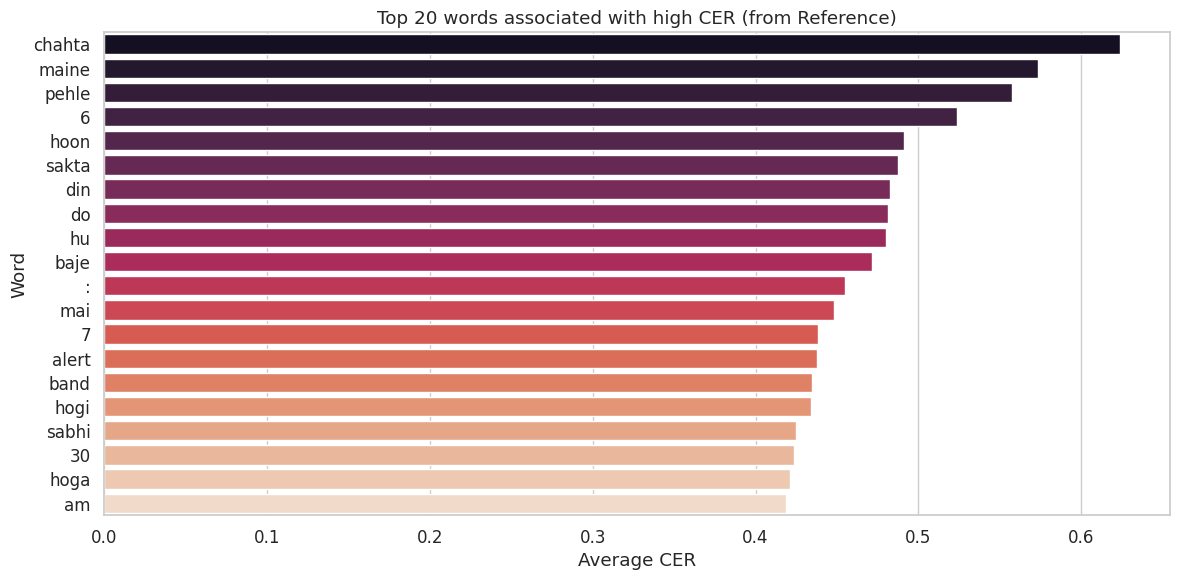

<ipython-input-11-56cb978e3ebd>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_BLEU', y='word', data=top_low_bleu, palette='mako')


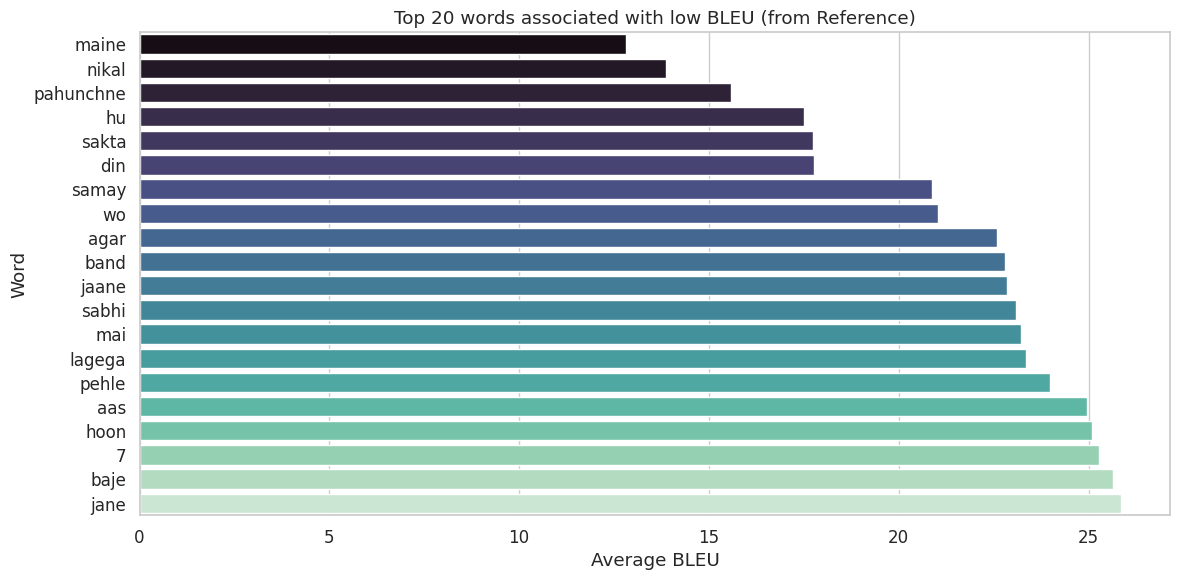

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict

# Read the text file (ensure the file 't5_small_metric_eval.txt' is in your working directory)
with open('/content/t5_base_metric_eval.txt', 'r', encoding='utf-8') as f:
    data = f.read()

# Each block is assumed to be separated by a blank line
blocks = data.strip().split('\n\n')

rows = []
for block in blocks:
    lines = block.strip().splitlines()
    if len(lines) >= 3:
        # Extract the Reference, Hypothesis, and metric line
        ref_line = lines[0]
        hyp_line = lines[1]
        metric_line = lines[2]
        # Remove the prefix 'Reference:' and 'Hypothesis:'
        ref = re.sub(r'^Reference:\s*', '', ref_line).strip()
        hyp = re.sub(r'^Hypothesis:\s*', '', hyp_line).strip()
        # Use regex to extract BLEU, WER, CER from the metric line
        m = re.findall(r'BLEU:\s*([\d\.]+),\s*WER:\s*([\d\.]+),\s*CER:\s*([\d\.]+)', metric_line)
        if m:
            bleu, wer, cer = map(float, m[0])
        else:
            continue
        rows.append({'Reference': ref, 'Hypothesis': hyp, 'BLEU': bleu, 'WER': wer, 'CER': cer})

# Create a DataFrame from the extracted data
df = pd.DataFrame(rows)

# Tokenize the Reference text into words (convert to lowercase and split on whitespace)
df['ref_tokens'] = df['Reference'].str.lower().str.split()

# Create a dictionary to accumulate metrics for each word appearing in the Reference
word_metrics = defaultdict(lambda: {'wer': [], 'bleu': [], 'cer': [], 'count': 0})

# For each row, add the metric values for each word in the Reference text.
# Here, we count every occurrence. You can modify this if you prefer to use a set.
for _, row in df.iterrows():
    for word in row['ref_tokens']:
        word_metrics[word]['wer'].append(row['WER'])
        word_metrics[word]['bleu'].append(row['BLEU'])
        word_metrics[word]['cer'].append(row['CER'])
        word_metrics[word]['count'] += 1

# Build a DataFrame with average metrics per word
words = []
avg_wer = []
avg_bleu = []
avg_cer = []
counts = []

for word, metrics in word_metrics.items():
    words.append(word)
    avg_wer.append(sum(metrics['wer']) / len(metrics['wer']))
    avg_bleu.append(sum(metrics['bleu']) / len(metrics['bleu']))
    avg_cer.append(sum(metrics['cer']) / len(metrics['cer']))
    counts.append(metrics['count'])

metrics_df = pd.DataFrame({
    'word': words,
    'avg_WER': avg_wer,
    'avg_BLEU': avg_bleu,
    'avg_CER': avg_cer,
    'count': counts
})

# Filter out words that do not appear frequently (set threshold to 5 occurrences)
filtered_df = metrics_df[metrics_df['count'] >= 5].copy()

# Set a Seaborn style for better aesthetics
sns.set(style="whitegrid", font_scale=1.1)

# Visualization 1: Top 20 words associated with high WER
top_wer = filtered_df.sort_values('avg_WER', ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x='avg_WER', y='word', data=top_wer, palette='viridis')
plt.title('Top 20 words associated with high WER (from Reference)')
plt.xlabel('Average WER')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

# Visualization 2: Top 20 words associated with high CER
top_cer = filtered_df.sort_values('avg_CER', ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x='avg_CER', y='word', data=top_cer, palette='rocket')
plt.title('Top 20 words associated with high CER (from Reference)')
plt.xlabel('Average CER')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

# Visualization 3: Top 20 words associated with low BLEU (lower BLEU implies worse quality)
top_low_bleu = filtered_df.sort_values('avg_BLEU', ascending=True).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x='avg_BLEU', y='word', data=top_low_bleu, palette='mako')
plt.title('Top 20 words associated with low BLEU (from Reference)')
plt.xlabel('Average BLEU')
plt.ylabel('Word')
plt.tight_layout()
plt.show()


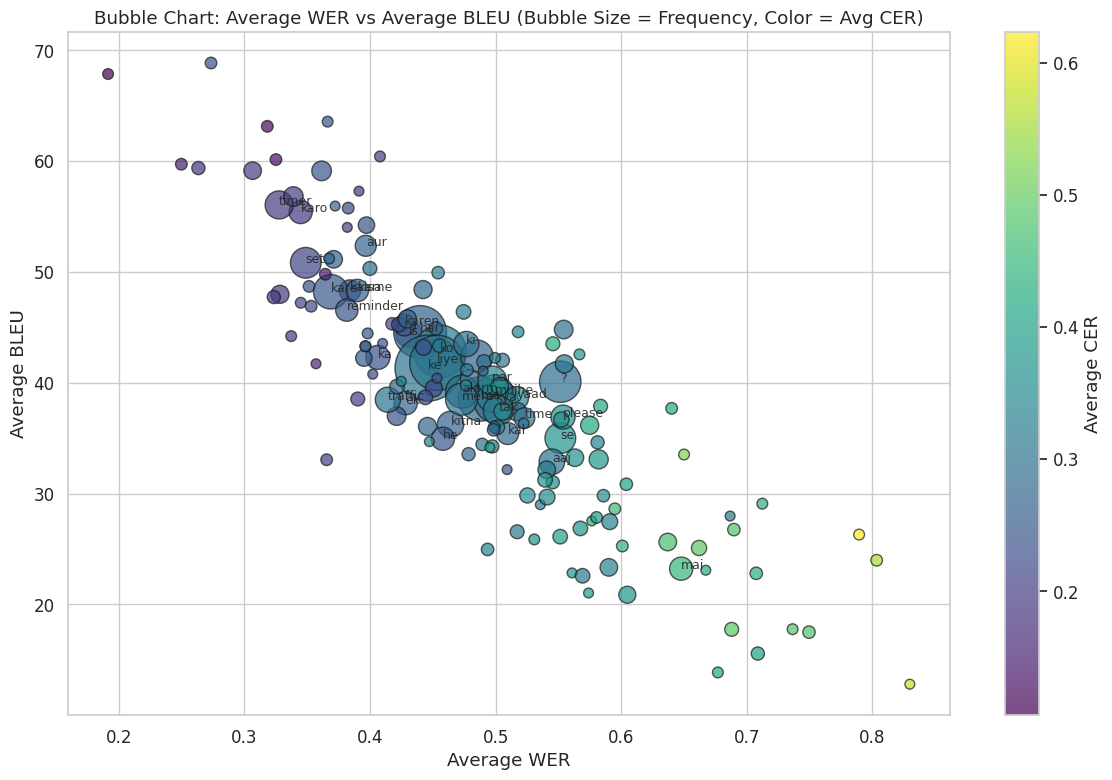

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bubble chart using the filtered DataFrame (filtered_df from previous code)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    filtered_df['avg_WER'],
    filtered_df['avg_BLEU'],
    s=filtered_df['count'] * 10,  # adjust multiplier for better bubble sizes
    c=filtered_df['avg_CER'],
    cmap='viridis',
    alpha=0.7,
    edgecolor='k'
)
plt.xlabel('Average WER')
plt.ylabel('Average BLEU')
plt.title('Bubble Chart: Average WER vs Average BLEU (Bubble Size = Frequency, Color = Avg CER)')
cbar = plt.colorbar(scatter)
cbar.set_label('Average CER')

# Annotate a few high-frequency words for illustration purposes
for _, row in filtered_df.iterrows():
    if row['count'] > 20:  # annotate words that appear very frequently
        plt.annotate(row['word'], (row['avg_WER'], row['avg_BLEU']), fontsize=9, alpha=0.9)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Read the data
def parse_metrics_file(file_path):
    metrics = []
    with open(file_path, 'r', encoding='utf-8') as file:
        current_entry = {}
        for line in file:
            line = line.strip()
            if line.startswith('Reference:'):
                current_entry['reference'] = line.replace('Reference: ', '')
            elif line.startswith('Hypothesis:'):
                current_entry['hypothesis'] = line.replace('Hypothesis: ', '')
            elif line.startswith('BLEU:'):
                # Extract numeric values
                bleu = float(line.split('BLEU:')[1].split(',')[0].strip())
                wer = float(line.split('WER:')[1].split(',')[0].strip())
                cer = float(line.split('CER:')[1].strip())

                current_entry['bleu'] = bleu
                current_entry['wer'] = wer
                current_entry['cer'] = cer

                metrics.append(current_entry)
                current_entry = {}

    return pd.DataFrame(metrics)

# Load the data (replace with your file path)
df = parse_metrics_file('/content/t5_base_metric_eval.txt')

# 1. Interactive Correlation Heatmap
def create_correlation_heatmap(df):
    correlation_matrix = df[['bleu', 'wer', 'cer']].corr()

    fig = px.imshow(correlation_matrix,
                    labels=dict(x="Metrics", y="Metrics", color="Correlation"),
                    x=['BLEU', 'WER', 'CER'],
                    y=['BLEU', 'WER', 'CER'],
                    color_continuous_scale='RdBu_r',
                    title='Correlation Between NLP Metrics')
    fig.show()
    return fig

# 2. Distribution of Metrics
def create_metrics_distribution(df):
    fig = make_subplots(rows=1, cols=3,
                        subplot_titles=('BLEU Score Distribution',
                                        'WER Distribution',
                                        'CER Distribution'))

    for i, metric in enumerate(['bleu', 'wer', 'cer'], 1):
        fig.add_trace(
            go.Histogram(x=df[metric], name=metric.upper()),
            row=1, col=i
        )

    fig.update_layout(title_text="Distribution of NLP Metrics")
    fig.show()
    return fig

# 3. Length Impact Analysis
def create_length_impact_analysis(df):
    df['ref_length'] = df['reference'].str.len()
    df['hyp_length'] = df['hypothesis'].str.len()

    fig = make_subplots(rows=1, cols=3,
                        subplot_titles=('Reference Length vs BLEU',
                                        'Reference Length vs WER',
                                        'Reference Length vs CER'))

    # BLEU vs Length
    fig.add_trace(
        go.Scatter(x=df['ref_length'], y=df['bleu'], mode='markers',
                   name='BLEU', marker=dict(color='blue', opacity=0.6)),
        row=1, col=1
    )

    # WER vs Length
    fig.add_trace(
        go.Scatter(x=df['ref_length'], y=df['wer'], mode='markers',
                   name='WER', marker=dict(color='red', opacity=0.6)),
        row=1, col=2
    )

    # CER vs Length
    fig.add_trace(
        go.Scatter(x=df['ref_length'], y=df['cer'], mode='markers',
                   name='CER', marker=dict(color='green', opacity=0.6)),
        row=1, col=3
    )

    fig.update_layout(title_text="Impact of Reference Length on Metrics")
    fig.update_xaxes(title_text="Reference Length")
    fig.update_yaxes(title_text="Metric Value")

    fig.show()
    return fig

# 4. Word Frequency Analysis
def create_word_frequency_analysis(df):
    import re
    from collections import Counter

    def extract_words(text):
        return re.findall(r'\b\w+\b', text.lower())

    # Collect words from references and hypotheses
    ref_words = [word for text in df['reference'] for word in extract_words(text)]
    hyp_words = [word for text in df['hypothesis'] for word in extract_words(text)]

    # Top 20 most frequent words
    ref_word_freq = Counter(ref_words).most_common(20)
    hyp_word_freq = Counter(hyp_words).most_common(20)

    # Create subplots for word frequencies
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Top Words in References',
                                        'Top Words in Hypotheses'))

    # References word frequency
    fig.add_trace(
        go.Bar(x=[word[0] for word in ref_word_freq],
               y=[word[1] for word in ref_word_freq],
               name='Reference Words'),
        row=1, col=1
    )

    # Hypotheses word frequency
    fig.add_trace(
        go.Bar(x=[word[0] for word in hyp_word_freq],
               y=[word[1] for word in hyp_word_freq],
               name='Hypothesis Words'),
        row=1, col=2
    )

    fig.update_layout(title_text="Word Frequency Analysis")
    fig.show()
    return fig

# 5. Advanced Scatter Plot
def create_advanced_scatter(df):
    fig = px.scatter(df, x='wer', y='bleu', color='cer',
                     title='WER vs BLEU Colored by CER',
                     labels={'wer': 'Word Error Rate',
                             'bleu': 'BLEU Score',
                             'cer': 'Character Error Rate'},
                     color_continuous_scale='viridis')
    fig.show()
    return fig

# 6. PCA Visualization
def create_pca_visualization(df):
    # Feature Engineering
    df['ref_unique_words'] = df['reference'].apply(lambda x: len(set(x.split())))
    df['hyp_unique_words'] = df['hypothesis'].apply(lambda x: len(set(x.split())))
    df['ref_word_diversity'] = df['ref_unique_words'] / df['reference'].apply(lambda x: len(x.split()))
    df['hyp_word_diversity'] = df['hyp_unique_words'] / df['hypothesis'].apply(lambda x: len(x.split()))

    # Prepare data for PCA
    features_for_pca = ['bleu', 'wer', 'cer', 'ref_unique_words', 'hyp_unique_words',
                        'ref_word_diversity', 'hyp_word_diversity']

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[features_for_pca])

    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)

    # Create DataFrame for plotting
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    pca_df['BLEU'] = df['bleu']

    # Interactive PCA plot
    fig = px.scatter(pca_df, x='PC1', y='PC2', color='BLEU',
                     title='PCA of NLP Metrics',
                     labels={'PC1': 'First Principal Component',
                             'PC2': 'Second Principal Component'},
                     color_continuous_scale='viridis')

    # Add variance explained annotation
    variance_explained = pca.explained_variance_ratio_
    fig.add_annotation(
        text=f'Variance Explained:<br>PC1: {variance_explained[0]*100:.2f}%<br>PC2: {variance_explained[1]*100:.2f}%',
        xref='paper', yref='paper',
        x=0.05, y=0.95,
        showarrow=False
    )

    fig.show()
    return fig

# Execute all visualizations
print("1. Correlation Heatmap")
create_correlation_heatmap(df)

print("\n2. Metrics Distribution")
create_metrics_distribution(df)

print("\n3. Length Impact Analysis")
create_length_impact_analysis(df)

print("\n4. Word Frequency Analysis")
create_word_frequency_analysis(df)

print("\n5. Advanced Scatter Plot")
create_advanced_scatter(df)

print("\n6. PCA Visualization")
create_pca_visualization(df)

# Print Descriptive Statistics
print("\nDescriptive Statistics:")
print(df[['bleu', 'wer', 'cer']].describe())

# Correlation Analysis
print("\nCorrelation Analysis:")
print(df[['bleu', 'wer', 'cer']].corr())

1. Correlation Heatmap



2. Metrics Distribution



3. Length Impact Analysis



4. Word Frequency Analysis



5. Advanced Scatter Plot



6. PCA Visualization



Descriptive Statistics:
             bleu         wer         cer
count  500.000000  500.000000  500.000000
mean    42.205705    0.459008    0.282621
std     27.594596    0.280828    0.221950
min      3.009800    0.000000    0.000000
25%     18.670800    0.250000    0.090900
50%     35.997450    0.428600    0.240000
75%     61.019500    0.666700    0.434350
max    100.000000    1.500000    1.071400

Correlation Analysis:
          bleu       wer       cer
bleu  1.000000 -0.808335 -0.747347
wer  -0.808335  1.000000  0.898358
cer  -0.747347  0.898358  1.000000


# Comprehensive Analysis of NLP Metrics Visualizations

## 1. Correlation Heatmap
### What it Represents:
The correlation heatmap shows the statistical relationship between BLEU, WER (Word Error Rate), and CER (Character Error Rate) scores.

#### Key Insights:
- **Color Interpretation**:
  - Red indicates negative correlation
  - Blue indicates positive correlation
  - Darker colors represent stronger correlations
  - White or light colors suggest weak or no correlation

#### Possible Scenarios:
- A strong negative correlation between BLEU and WER would suggest that as Word Error Rate increases, BLEU score decreases
- Moderate correlations might indicate complex interactions between metrics
- Weak correlations suggest the metrics capture different aspects of translation quality

## 2. Metrics Distribution
### What it Represents:
This visualization shows the frequency distribution of BLEU, WER, and CER scores.

#### Key Insights:
- **Shape of Distribution**:
  - Normal (bell-curve) distribution suggests consistent performance
  - Skewed distribution indicates bias in translation quality
  - Multiple peaks might suggest distinct performance groups

#### Interpretation:
- Peak location shows the most common score range
- Width of distribution indicates performance variability
- Outliers represent exceptional cases of very good or poor translations

## 3. Length Impact Analysis
### What it Represents:
Explores how text length affects different NLP metrics (BLEU, WER, CER).

#### Key Insights:
- **Relationship Between Length and Metrics**:
  - Clustering of points suggests consistent performance
  - Scattered points indicate high variability
  - Trend lines (if visible) show how metrics change with text length

#### Potential Observations:
- Do longer texts have more consistent or more variable metrics?
- Is there a sweet spot for text length that yields optimal performance?
- How do different metrics respond to text length?

## 4. Word Frequency Analysis
### What it Represents:
Displays the most frequently occurring words in references and hypotheses.

#### Key Insights:
- **Linguistic Patterns**:
  - Common words across references and hypotheses
  - Differences in word usage between reference and hypothesis
  - Potential impact of frequent words on translation quality

#### Potential Analysis:
- Identify most challenging words for translation
- Understand vocabulary complexity
- Detect potential systematic translation errors

## 5. Advanced Scatter Plot (WER vs BLEU)
### What it Represents:
A multi-dimensional view of Word Error Rate, BLEU Score, and Character Error Rate.

#### Key Insights:
- **Color Gradient**:
  - Represents Character Error Rate
  - Darker/lighter colors show variation in CER
- **Point Distribution**:
  - Clustering indicates consistent performance
  - Spread suggests high variability

#### Interpretation:
- Relationship between translation accuracy (WER)
- Impact of character-level errors on overall translation quality
- Identifying optimal performance regions

## 6. PCA (Principal Component Analysis) Visualization
### What it Represents:
Reduces multiple metrics to two principal components to show underlying patterns.

#### Key Insights:
- **Dimension Reduction**:
  - Combines multiple features into two principal components
  - Shows how different metrics interrelate
- **Color Coding**:
  - BLEU score represented by color gradient
  - Helps identify patterns in translation quality

#### Potential Discoveries:
- Hidden relationships between different metrics
- Clustering of translation performance
- Variance explained by principal components

## Descriptive Statistics Interpretation

### Mean (Average):
- Provides central tendency of metrics
- Indicates overall translation performance

### Standard Deviation:
- Measures variation in metrics
- High deviation suggests inconsistent translation quality

### Minimum and Maximum:
- Identifies extreme cases
- Shows the range of translation performance

## Correlation Analysis
### What it Represents:
Numerical representation of relationships between metrics.

#### Interpretation:
- Values close to 1 or -1 indicate strong correlation
- Values near 0 suggest weak or no correlation
- Helps understand how different metrics interact

## Research-Worthy Insights
1. **Performance Variability**: Analyze factors causing metric fluctuations
2. **Linguistic Complexity**: Understand how text characteristics impact translation
3. **Metric Interdependence**: Explore relationships between different evaluation metrics
4. **Error Pattern Recognition**: Identify systematic translation challenges
